In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
import verifyml.model_card_toolkit as mctlib
import verifyml.model_tests.utils as utils


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

sns.set_theme(style="whitegrid")

In [2]:
# Load training dataset
df_train = pd.read_csv('./dataset.csv')
X_train_full = df_train.iloc[:,1:].drop('target_variable', axis=1)

y_train_full = df_train['target_variable']

In [3]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

In [4]:
# create model instance
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

# fit model
bst.fit(X_train, y_train)

# make predictions
preds = bst.predict(X_test)

### Confusion matrix

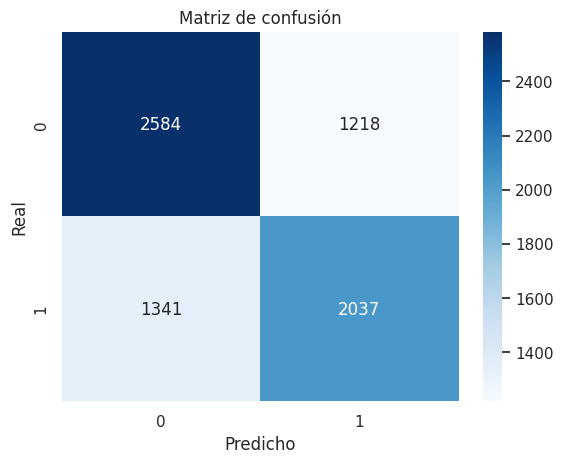

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

In [8]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3802
           1       0.63      0.60      0.61      3378

    accuracy                           0.64      7180
   macro avg       0.64      0.64      0.64      7180
weighted avg       0.64      0.64      0.64      7180



In [11]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el modelo base
bst = XGBClassifier(objective='binary:logistic')

# Espacio de búsqueda
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Búsqueda aleatoria (más rápida que GridSearch)
search = RandomizedSearchCV(
    estimator=bst,
    param_distributions=param_grid,
    n_iter=20,  # Número de combinaciones a probar
    scoring='f1',  # Optimizar F1-score
    cv=StratifiedKFold(n_splits=5),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Entrenar
search.fit(X_train, y_train)

# Mejor modelo
best_bst = search.best_estimator_
print("Mejores parámetros:", search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3802
           1       0.82      0.82      0.82      3378

    accuracy                           0.83      7180
   macro avg       0.83      0.83      0.83      7180
weighted avg       0.83      0.83      0.83      7180



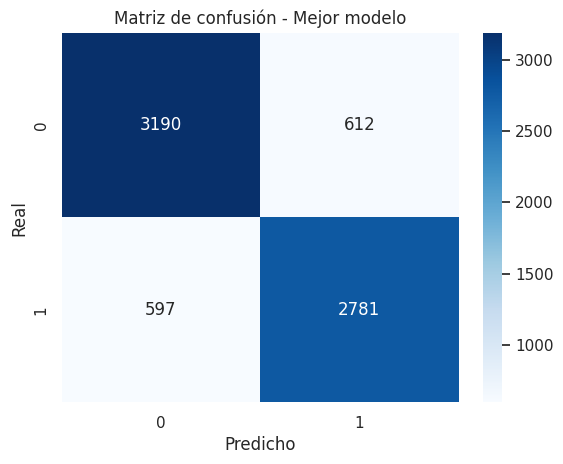

In [12]:
# Predecir con el mejor modelo
preds_best = best_bst.predict(X_test)

# Calcular métricas
print(classification_report(y_test, preds_best))

# Matriz de confusión
cm_best = confusion_matrix(y_test, preds_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión - Mejor modelo')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

In [ ]:
import shap

# Crear el explainer
explainer = shap.TreeExplainer(best_bst)

# Calcular los valores SHAP para tus datos de prueba
shap_values = explainer.shap_values(X_test)